<a href="https://colab.research.google.com/github/vinicius-mattoso/LearningHub/blob/main/time_series/02_HoltWinter_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Holt-Winters (ETS) Forecasting — AirPassengers

This notebook continues the Time Series track in **LearningHub**.

## Goals
- Understand the intuition behind **ETS / Holt-Winters**:
  - Level, Trend, Seasonality
  - Additive vs Multiplicative components
  - Damped trend (optional)
- Train/test split for time series
- Fit multiple Holt-Winters variants and compare using:
  - RMSE
  - MAPE
- Forecast test period + future horizon (24 months)

> This notebook focuses on **exponential smoothing models** (strong baselines for forecasting).


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

## 1. What is ETS / Holt-Winters?

ETS models are built around three possible components:

- **Level (L):** the baseline value of the series
- **Trend (T):** long-term direction (growth/decline)
- **Seasonality (S):** repeating pattern (e.g., 12 months)

Holt-Winters is essentially an ETS model with trend + seasonality.

### Additive vs Multiplicative
- **Additive seasonality:** seasonal effect has constant magnitude
- **Multiplicative seasonality:** seasonal effect scales with the level (common in AirPassengers)

### Damped trend
In some cases, trend is expected to slow down over time.
A damped trend variant prevents explosive forecasts.


In [2]:
DATA_URL = "https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv"

df = pd.read_csv(DATA_URL)
df.columns = [c.strip().lower() for c in df.columns]

if not {"date", "value"}.issubset(df.columns):
    raise ValueError(f"Expected columns date,value; got: {df.columns.tolist()}")

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")

y = df["value"].astype(float)

# Ensure month-end frequency
y.index = y.index.to_period("M").to_timestamp("M")
y = y.asfreq("ME")

y.head(), y.tail()

(date
 1949-01-31    112.0
 1949-02-28    118.0
 1949-03-31    132.0
 1949-04-30    129.0
 1949-05-31    121.0
 Freq: ME, Name: value, dtype: float64,
 date
 1960-08-31    606.0
 1960-09-30    508.0
 1960-10-31    461.0
 1960-11-30    390.0
 1960-12-31    432.0
 Freq: ME, Name: value, dtype: float64)

## 2. Quick visual inspection

We plot the raw series and use **multiplicative decomposition** as a reference:
AirPassengers typically shows variance and seasonality increasing with the level.

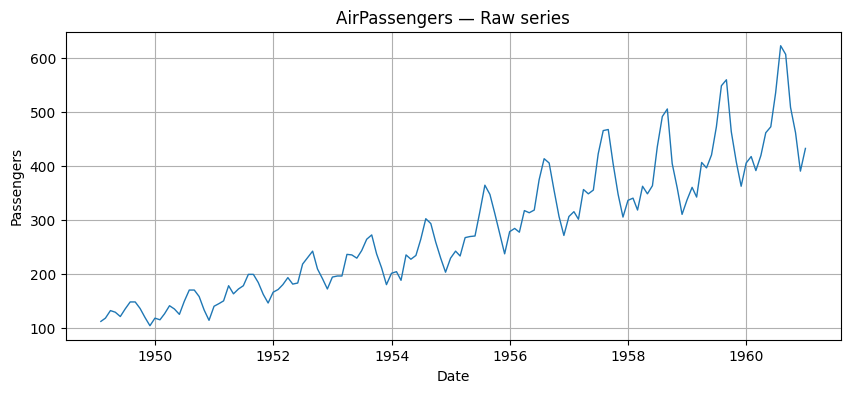

In [3]:
plt.figure()
plt.plot(y.index, y.values, linewidth=1)
plt.title("AirPassengers — Raw series")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()

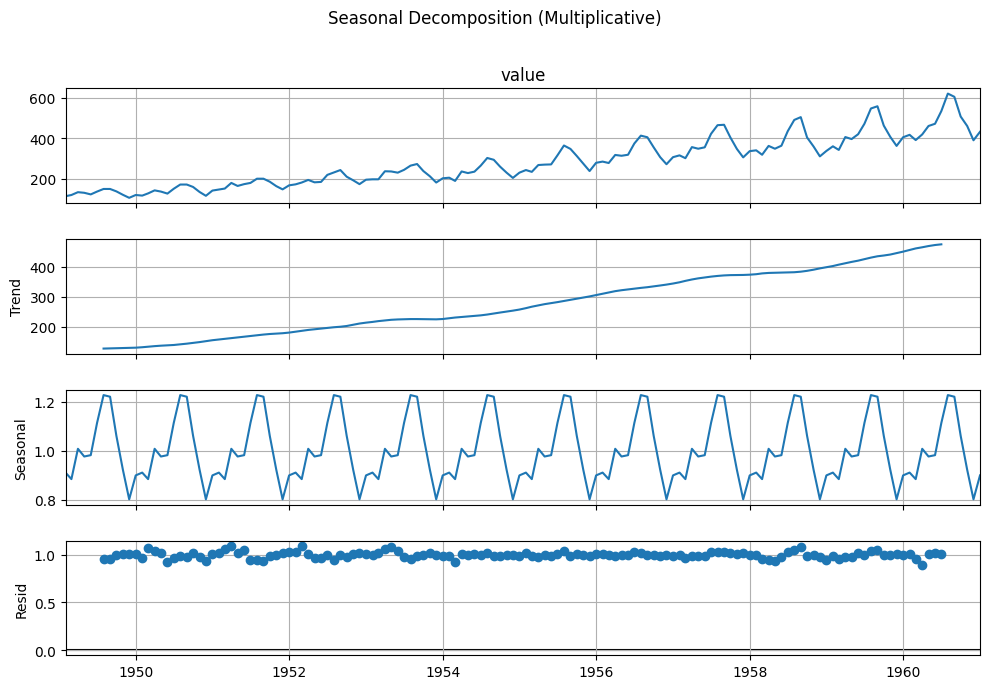

In [4]:
decomp = seasonal_decompose(y, model="multiplicative", period=12)
fig = decomp.plot()
fig.set_size_inches(10, 7)
plt.suptitle("Seasonal Decomposition (Multiplicative)", y=1.02)
plt.show()

## 3. Train/Test split (time-aware)

For time series, we split chronologically:
- Train: first 80%
- Test: last 20%

This simulates a real forecasting scenario.


In [5]:
train_size = int(len(y) * 0.8)
train = y.iloc[:train_size]
test = y.iloc[train_size:]

train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('1949-01-31 00:00:00'),
 Timestamp('1958-07-31 00:00:00'),
 Timestamp('1958-08-31 00:00:00'),
 Timestamp('1960-12-31 00:00:00'))

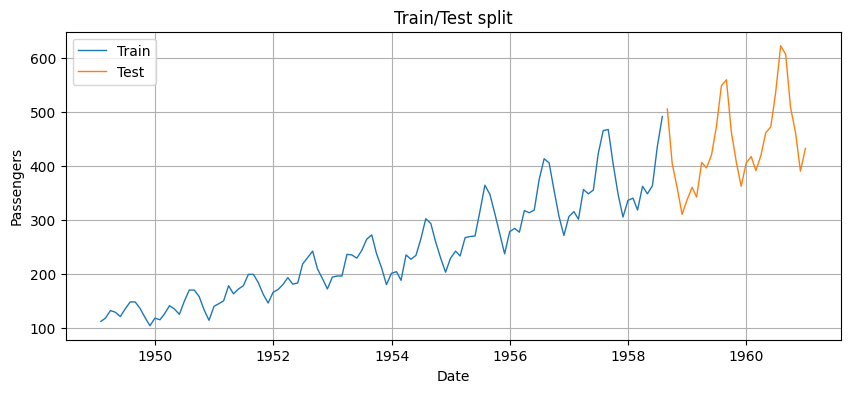

In [6]:
plt.figure()
plt.plot(train.index, train.values, label="Train", linewidth=1)
plt.plot(test.index, test.values, label="Test", linewidth=1)
plt.title("Train/Test split")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()


## 4. Metrics

We evaluate forecasts using:

- **RMSE**: penalizes large errors (scale-dependent)
- **MAPE**: error in percentage terms (interpretable, but sensitive near zero)

AirPassengers is strictly positive, so MAPE is fine here.


In [7]:
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    eps = 1e-9
    return float(np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0)

## 5. Holt-Winters candidates

We will fit multiple ETS variants:
- trend: add / mul / None
- seasonal: add / mul / None
- damped trend: True/False (when trend exists)

We compare models on the **test set**.


In [8]:
def fit_hw_and_forecast(train, test, trend, seasonal, damped=False, sp=12):
    model = ExponentialSmoothing(
        train,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=sp,
        damped_trend=damped if trend is not None else False,
        initialization_method="estimated",
    ).fit(optimized=True)

    pred = model.forecast(len(test))
    pred = pd.Series(pred, index=test.index)

    return {
        "trend": trend,
        "seasonal": seasonal,
        "damped": (damped if trend is not None else False),
        "rmse": rmse(test, pred),
        "mape": mape(test, pred),
        "aic": float(getattr(model, "aic", np.nan)),
        "bic": float(getattr(model, "bic", np.nan)),
        "model": model,
        "pred": pred
    }

In [9]:
candidates = [
    # (trend, seasonal, damped)
    ("add", "add", False),
    ("add", "mul", False),
    ("mul", "mul", False),
    ("add", "add", True),
    ("add", "mul", True),
]

results = []
errors = []

for tr, seas, damp in candidates:
    try:
        results.append(fit_hw_and_forecast(train, test, tr, seas, damped=damp, sp=12))
    except Exception as e:
        errors.append((tr, seas, damp, repr(e)))

if not results:
    raise RuntimeError(f"No Holt-Winters model fitted successfully. Errors: {errors}")

summary = pd.DataFrame([{
    "trend": r["trend"],
    "seasonal": r["seasonal"],
    "damped": r["damped"],
    "RMSE": r["rmse"],
    "MAPE(%)": r["mape"],
    "AIC": r["aic"],
    "BIC": r["bic"],
} for r in results]).sort_values("RMSE")

summary

,trend,seasonal,damped,RMSE,MAPE(%),AIC,BIC
2,mul,mul,False,21.334796,4.255907,487.959594,531.878508
1,add,mul,False,26.041880,4.818738,488.395592,532.314506
4,add,mul,True,37.982540,6.653175,492.032982,538.696828
0,add,add,False,39.255596,6.707875,588.686595,632.605509
3,add,add,True,51.917014,9.297492,593.763643,640.427489


In [10]:
best_idx = summary.index[0]
best = results[list(summary.index).index(best_idx)]  # map sorted index to results

best["trend"], best["seasonal"], best["damped"], best["rmse"], best["mape"]

('add', 'add', False, 39.25559585590603, 6.707875279413872)

## 6. Interpreting the best model

For AirPassengers, it is common that models with **multiplicative seasonality** perform better,
because seasonal amplitude grows with the series level.

Damped trend may help avoid overly optimistic extrapolations, depending on the split and horizon.


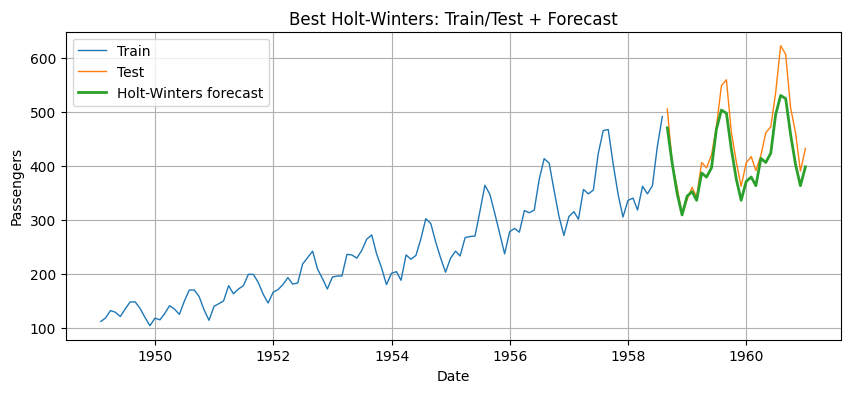

In [11]:
plt.figure()
plt.plot(train.index, train.values, label="Train", linewidth=1)
plt.plot(test.index, test.values, label="Test", linewidth=1)
plt.plot(best["pred"].index, best["pred"].values, label="Holt-Winters forecast", linewidth=2)
plt.title("Best Holt-Winters: Train/Test + Forecast")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

## 7. Forecasting the next 24 months

After selecting the best specification, we refit the model on the full series
and forecast the next 24 months.

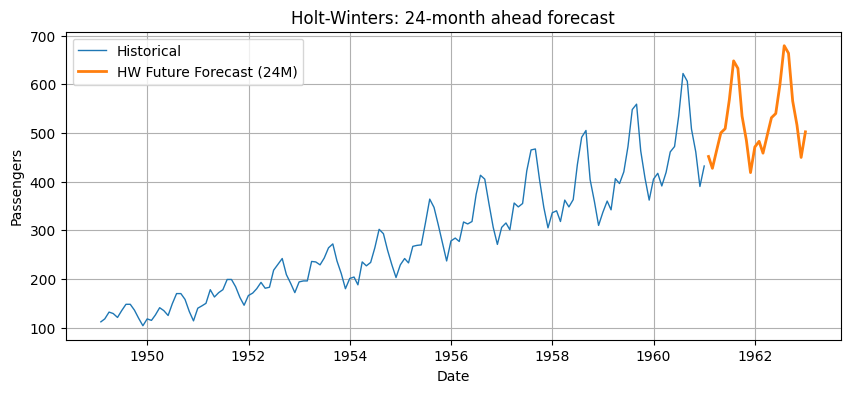

,forecast
1961-01-31,451.576310
1961-02-28,427.256384
1961-03-31,464.696765
1961-04-30,500.101255
1961-05-31,508.658613


In [12]:
best_full = ExponentialSmoothing(
    y,
    trend=best["trend"],
    seasonal=best["seasonal"],
    seasonal_periods=12,
    damped_trend=best["damped"] if best["trend"] is not None else False,
    initialization_method="estimated",
).fit(optimized=True)

h = 24
future_fc = best_full.forecast(h)

future_index = pd.date_range(
    start=y.index[-1] + pd.offsets.MonthEnd(1),
    periods=h,
    freq="ME"
)

future_fc = pd.Series(future_fc.values, index=future_index)

plt.figure()
plt.plot(y.index, y.values, label="Historical", linewidth=1)
plt.plot(future_fc.index, future_fc.values, label="HW Future Forecast (24M)", linewidth=2)
plt.title("Holt-Winters: 24-month ahead forecast")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()

future_fc.to_frame("forecast").head()


## 8. Key takeaways

- Holt-Winters (ETS) provides strong forecasting baselines with simple interpretable components.
- AirPassengers typically benefits from **multiplicative seasonality**.
- A time-aware train/test split is essential for realistic evaluation.
- ETS models are often competitive even before moving to ARIMA/SARIMA or ML models.

